# How are returns and volatility related for energy stocks and the broader market?

**Analytical Context.** The data you've been given is in the Comma Separated Value (CSV) format, and comprises price and trading volume data for the above stocks. You will proceed by: (1) conducting preliminary cleaning of the data; (2) creating additional features required for our analysis; (3) labelling the data into volatility groups, or regimes, and determining how volatility is related to returns; and finally (4) comparing these returns against those of the broader market.

In [1]:
# Import libraries required for this case
import pandas as pd
import numpy as np

## Preliminary cleaning of the data

Before we can proceed with data analysis and modeling, we first need to determine if the relevant data is adequate to proceed as-is, or if it needs further cleaning. In this case, we have received a Comma Separated Value (CSV) file that includes the following data:

1. **Date:** The day of the year
2. **Open:** The stock opening price of the day
3. **High:** The highest observed stock price of the day
4. **Low:** The lowest observed stock price of the day
5. **Close:** The stock closing price of the day
6. **Adj Close:** The adjusted stock closing price for the day (adjusted for splits and dividends)
7. **Volume:** The volume of the stock traded over the day
8. **Symbol:** The symbol for that particular stock

One very common problem that arises in datasets is missing values. Let's see how to identify whether or not our dataset has this problem, and how to deal with missing values.

In [2]:
# Load and view head of DataFrame
raw_df = pd.read_csv('EnergySectorData.csv')
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2014-07-28,69.750000,71.059998,69.750000,70.879997,57.963978,1806400.0,D
1,2014-07-29,70.669998,70.980003,69.930000,69.930000,57.187099,2231100.0,D
2,2014-07-30,70.000000,70.660004,68.400002,68.970001,56.402020,2588900.0,D
3,2014-07-31,68.629997,68.849998,67.580002,67.639999,55.314388,3266900.0,D
4,2014-08-01,67.330002,68.410004,67.220001,67.589996,55.273487,2601800.0,D


Let's begin by determining if we have missing values. We can use the ```pandas``` DataFrame method ```isnull()``` to check for ```NaN``` values in ```raw_df``` (i.e. check for null values):

In [3]:
# Check if there are missing values (NaNs)
raw_df.isnull().sum()

Date          0
Open          2
High         14
Low           7
Close         7
Adj Close     7
Volume       22
Symbol        0
dtype: int64

Here we see we have some missing values. Let's instead use the ```mean()``` method to determine what percent of each column we are missing.

In [4]:
raw_df.isnull().mean()*100

Date         0.000000
Open         0.031873
High         0.223108
Low          0.111554
Close        0.111554
Adj Close    0.111554
Volume       0.350598
Symbol       0.000000
dtype: float64

We see here that we are missing less than 0.5% of the observations in any given column. 



### Exercise 1:
We do not want any missing values in our analysis. Which of the following options is the WORST option for how to proceed in this case?

(a) Fill in any day's missing value with the previous day's value

(b) Replace the missing values by re-gathering the data

(c) Estimate the missing values by interpolating them from the values of other, similar data points

(d) Remove rows from the dataset that contain missing values

**Answer.** (a). We have a couple options that are generally acceptable on how to proceed with missing values:

1. One option is to replace the missing values by re-gathering the data. However, this option is often quite expensive in real man-hours, so we will forgo it for now.

2. Another option is to try to estimate the missing values using some reasonable estimation method, interpolating from other data points. However, this can be complicated and given that such a little amount of our data is missing, we will forgo this option.

3. In practice, a regularly chosen option when only a small amount of data is missing is to just remove the rows that have missing data. This option is generally fine to perform so long as the removed data is an insignificant portion of the data under study. Here we will choose this option as it simplifies the analysis and should not harm any results moving forward.

Answer (a) is problematic because replacing a missing value with the previous day's value doesn't make sense for stocks because stock prices and trading volumes are known to move day-to-day rather than remain unchanged for an extended period of time. Since we will be dealing with daily returns and volatility, this is especially problematic as it defaults any missing day's volatility and return to 0.

Note that these options for cleaning data should be carefully weighed when commencing a new data science study.

Let's clean the missing values by removing them from the data set.

In [5]:
# Remove NaNs from data
# Drop the missing values
progress_df = raw_df.dropna()

## Standardizing dates

We'd like to be able to analyze these stocks together across time. This would be easier is if all the stocks contained non-missing data for the same set of dates. Let's first ascertain if this is the case. One way to do this is to use the ```groupby``` method to group by ```Date```, then use the ```count()``` function to enumerate how many distinct dates we have. Since there are a total of 1259 rows per symbol, there should be a count of 1259 for each symbol.

In [6]:
# How many data rows do we have for each Symbol
progress_df.groupby('Symbol').count()

,Date,Open,High,Low,Close,Adj Close,Volume
Symbol,,,,,,,
D,1230,1230,1230,1230,1230,1230,1230
DUK,1249,1249,1249,1249,1249,1249,1249
EXC,1239,1239,1239,1239,1239,1239,1239
NEE,1251,1251,1251,1251,1251,1251,1251
SO,1259,1259,1259,1259,1259,1259,1259


Since most symbols do not have a count of 1259 for their ```Date``` columns, there are clearly some inconsistent values. Some of these duplicates will be missing values (NaNs), so let's enumerate those again first:

In [7]:
# Check if there are missing values (NaNs)
raw_df.isnull().sum()

Date          0
Open          2
High         14
Low           7
Close         7
Adj Close     7
Volume       22
Symbol        0
dtype: int64

As discussed earlier, we can remove missing values as there are not many samples that are missing, and dropping a small number of dates is not expected to significantly impact the analysis:

In [8]:
# Drop the missing values
progress_df = raw_df.dropna().copy()

In [9]:
# How many data rows do we have for each Symbol
progress_df.groupby('Symbol').count()

,Date,Open,High,Low,Close,Adj Close,Volume
Symbol,,,,,,,
D,1230,1230,1230,1230,1230,1230,1230
DUK,1249,1249,1249,1249,1249,1249,1249
EXC,1239,1239,1239,1239,1239,1239,1239
NEE,1251,1251,1251,1251,1251,1251,1251
SO,1259,1259,1259,1259,1259,1259,1259


Still, we see that different symbols have different numbers of dates. We'd like all the symbols to have the same set of dates for analysis purposes. Let's create a new ```clean_df``` that corresponds to a DataFrame with the same number of rows for each ```Symbol```, where all symbols share the same set of dates:

In [10]:
set_dates_D = set(progress_df[progress_df['Symbol'] == 'D']['Date'])
set_dates_EXC = set(progress_df[progress_df['Symbol'] == 'EXC']['Date'])
set_dates_NEE = set(progress_df[progress_df['Symbol'] == 'NEE']['Date'])
set_dates_SO = set(progress_df[progress_df['Symbol'] == 'SO']['Date'])
set_dates_DUK = set(progress_df[progress_df['Symbol'] == 'DUK']['Date'])
set_unique_dates = set.intersection(set_dates_D,set_dates_EXC,set_dates_NEE,set_dates_SO,set_dates_DUK)

In [11]:
# Filter new DataFrame for only the dates that are present in every symbol (i.e. the overlapping dates)
clean_df = progress_df[progress_df['Date'].isin(set_unique_dates)].copy()

In [12]:
# Let's take a look
clean_df.groupby('Symbol').count()

,Date,Open,High,Low,Close,Adj Close,Volume
Symbol,,,,,,,
D,1192,1192,1192,1192,1192,1192,1192
DUK,1192,1192,1192,1192,1192,1192,1192
EXC,1192,1192,1192,1192,1192,1192,1192
NEE,1192,1192,1192,1192,1192,1192,1192
SO,1192,1192,1192,1192,1192,1192,1192


Now we see that each symbol has the same number of unique dates. Let's write a quick verification program to ensure the resulting ```clean_df``` does indeed have the same dates for every symbol.

### Exercise 2:
Write code to ensure that each of the symbols share the same set of unique dates. (Hint: use the ```set()``` method.)

In [13]:
for i in clean_df:
    check_set_dates_D = set(clean_df[clean_df['Symbol'] == 'D']['Date'])
    check_set_dates_EXC = set(clean_df[clean_df['Symbol'] == 'EXC']['Date'])
    check_set_dates_NEE = set(clean_df[clean_df['Symbol'] == 'NEE']['Date'])
    check_set_dates_SO = set(clean_df[clean_df['Symbol'] == 'SO']['Date'])
    check_set_dates_DUK = set(clean_df[clean_df['Symbol'] == 'DUK']['Date'])

**Answer.** One possible solution is given below:

In [14]:
# One possible solution
check_set_dates_D = set(clean_df[clean_df['Symbol'] == 'D']['Date'])
check_set_dates_EXC = set(clean_df[clean_df['Symbol'] == 'EXC']['Date'])
check_set_dates_NEE = set(clean_df[clean_df['Symbol'] == 'NEE']['Date'])
check_set_dates_SO = set(clean_df[clean_df['Symbol'] == 'SO']['Date'])
check_set_dates_DUK = set(clean_df[clean_df['Symbol'] == 'DUK']['Date'])

print(check_set_dates_D == check_set_dates_EXC)
print(check_set_dates_D == check_set_dates_NEE)
print(check_set_dates_D == check_set_dates_SO)
print(check_set_dates_D == check_set_dates_DUK)

True
True
True
True


Now that we've completed the preliminary cleaning of the data, let's move forward with determining the relationships between: (1) stock returns and volatility, and (2) stock returns and broader market returns.

Notice that the ```apply()``` method takes in an anonymous function and applies it to the rows of the DataFrame through the use of the second argument ```axis```. ```axis=0``` applies the function to columns, whereas ```axis=1``` applies the function to rows.

So what is happening in the following statement?
```python
clean_df['ReturnFlag'] = clean_df.apply(lambda row: True if row['Return'] > 0 else False, axis=1)
```

1. ```pandas``` recognized through the ```apply``` method that it is operating on the ```clean_df``` DataFrame
2. The ```apply``` method takes a function as input that will be applied to the DataFrame ```clean_df```
3. Given the second argument of ```apply``` is ```axis=1``` the input into the anonymous function is a single row
4. For every row, ```row['Return']``` returns the ```Return``` value for that row, and it is subsequently passed through the if statement, returning True if greater than zero and False otherwise
5. The new value is stored in the column ```clean_df['ReturnFlag']```

### Exercise 3:

Using ```apply()``` and ```lambda```, write code to create a new column named ```YYYY``` to ```clean_df```, where the new column is the year of the observation as a string. For instance if the row ```Date``` value is 2014-07-28, then the value in the new column for the year would be '2014'. Recall that you can access the first 4 characters of some string ```my_string``` using ```my_string[:4]```.

**Answer.** One possible solution is given below:

In [15]:
# One possible solution
clean_df['YYYY'] = clean_df.apply(lambda row: row['Date'][:4], axis=1)

Let's move forward with labelling volatility regimes present in the data – these regimes are useful for breaking down the stock return analysis by periods of low, medium, and high volatility. It will allow for more granular analysis than just looking at overall averages without a breakdown.

In [16]:
clean_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,YYYY
0,2014-07-28,69.750000,71.059998,69.750000,70.879997,57.963978,1806400.0,D,2014
1,2014-07-29,70.669998,70.980003,69.930000,69.930000,57.187099,2231100.0,D,2014
2,2014-07-30,70.000000,70.660004,68.400002,68.970001,56.402020,2588900.0,D,2014
3,2014-07-31,68.629997,68.849998,67.580002,67.639999,55.314388,3266900.0,D,2014
4,2014-08-01,67.330002,68.410004,67.220001,67.589996,55.273487,2601800.0,D,2014


### Exercise 4:
Using ```apply()``` and ```lambda```, write a script to create a new column in ```clean_df``` named ```AvgDailyPrice``` that calculates an average daily price based on whether or not the daily volume is over 5 million. Set the value of the new column to (Open + High + Low + Close)/4 if the volume is larger than 5 million, or set the value to (High + Low + Close)/3 if the volume is less than or equal to 5 million.

In [17]:
clean_df['AvgDailyPrice'] = clean_df.apply(lambda row:(row['Open']+row['High']+row['Low']+row['Close'])/4 if row['Volume'] > 5000000 else (row['High']+row['Low']+row['Close'])/3, axis=1)
clean_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,YYYY,AvgDailyPrice
0,2014-07-28,69.750000,71.059998,69.750000,70.879997,57.963978,1806400.0,D,2014,70.563332
1,2014-07-29,70.669998,70.980003,69.930000,69.930000,57.187099,2231100.0,D,2014,70.280001
2,2014-07-30,70.000000,70.660004,68.400002,68.970001,56.402020,2588900.0,D,2014,69.343336
3,2014-07-31,68.629997,68.849998,67.580002,67.639999,55.314388,3266900.0,D,2014,68.023333
4,2014-08-01,67.330002,68.410004,67.220001,67.589996,55.273487,2601800.0,D,2014,67.740000


# How to get information for data analytics at OI?

# Introduction

**Business Context.** You work at O-I glass inc, the company is giving you the opportunity to receive training in Data Science, now that you have defined a project to work on during the training, you need to gather the data that is expected to help answer the business question.

**Business Problem.**  Your team needs to gather data for answering the business questions.

**Analytical Context.** You need to define the data source or sources that may contain relevant information that helps to solve the business problem. There are many possible scenarios, for example, your problem could be solved from a single data set which you may already have access to, in the other hand, there are some problems that might require to create new data or implement a new data gathering strategy. 

## Data sources at OI

The company produces a large amount of data, for every business function there is a whole world of yet to explore data and analitycs to be made, for example, Finance produces data in the form of transactions recorded to the ERP systems, Information Technology produces logs for each application, Manufacturing is constantly recording to databases information about the machines and the production, every single e-mail sent or received is a potential source of insights yet to be discovered. <br>
Does OI has Big Data? Yes, you could say so by definition as it complies with the three main characteristics Volume, Velocity and Variety, however, as February 28th 2020 there is no a Big Data Tool that help us manage our data from a single repository nor a data catalog that we could ask where to find a specific measure.

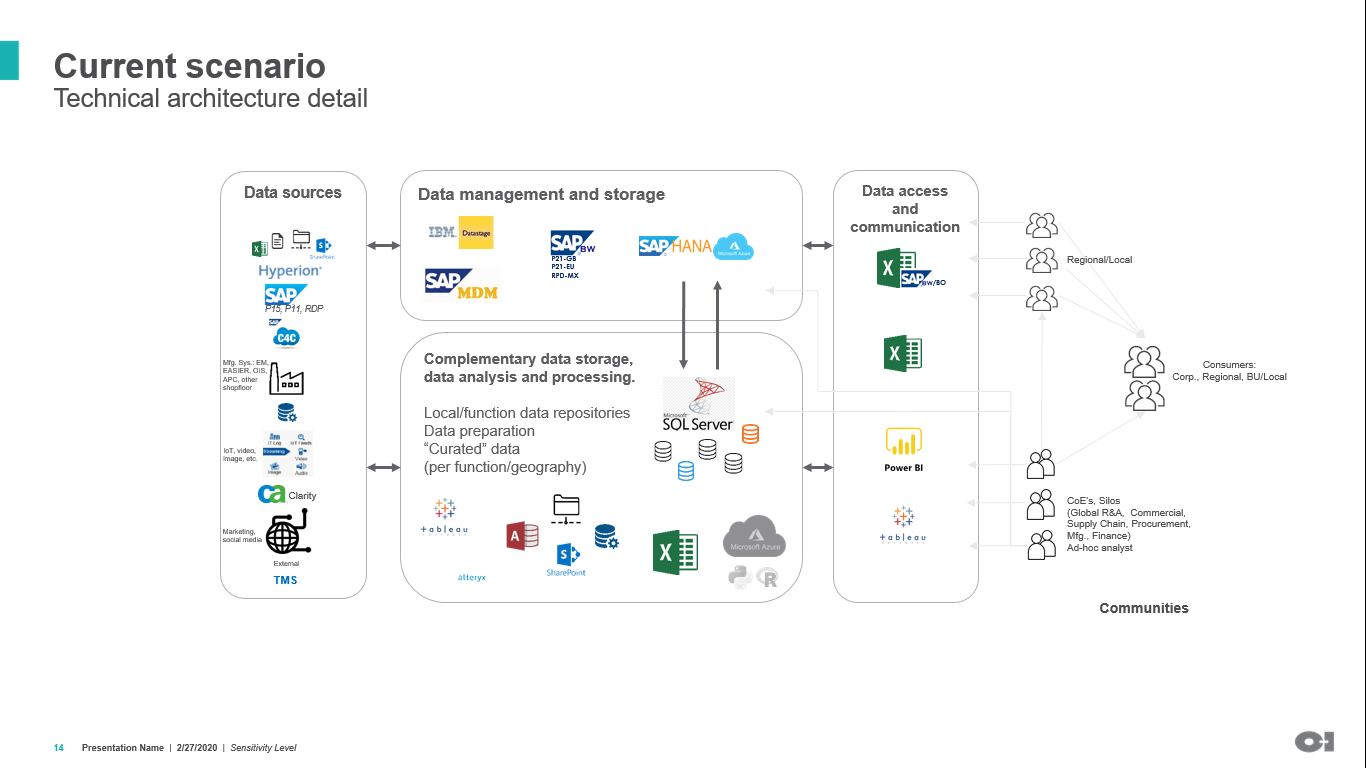

### SAP ECC

SAP ERP Central Component (ECC) or better known at the company simply as their systems names P15, P11 and RPD, is a transactional system which implies that records are constantly being created and manipulated. A regularly good assumption is that the data in ECC is actual and true.

The primary method of extraction is using SAP GUI, and to enter to any specific transaction (program/report) that generates tables with data and then export the results to Excel or plain text files. Some users from areas like Master Data or IT analysts might have access to SAP Tables through transactions like SE16N that allows for a quick search of RAW data, which could be easier to export and manipulate but requieres an advanced knowledge about how the system is built. Some data from ECC is consolidated on a daily basis in BW reports and HANA views.

**Avoid using ECC system for generating large datasets on a regular basis, this is a transactional system and its performance could be impacted negatively by indiscriminately using it for this purpose.**

### SAP MDM

SAP Master Data Management software is a platform to consolidate, cleanse and synchronise a single version of the truth for master data within a heterogeneus application landscape. Information about Customers, Vendors and Materials between others are maintained from this tool.

There are already some extractions from this system to plain text files that are performed on a regular basis from batch jobs properly configured by MDM technical team. Ask the MDM team from the shared service center for support and access to this extractions.

### SAP SCM

SAP Supply Chain Managment covers areas of production planning, business forecasting and demand planning. Usually referred as P45 or APO which is a planning tool inside this SAP solution.

#### Bonus Exercise1: Request your Planning or Supply Chain colleagues to talk about APO methods for accesing the information and what specific data can be found there.

### SAP BW

SAP Business Warehouse (BW) is an Enterprise Data Warehouse solution that can transform and consolidate information from any SAP system and some other sources, the information is presented in the form of Cubes or reports (info queries/info providers).

BW is commonly accessed using Bex Analyzer which is an Excel complement that connects to the system and allows to configure the parameters to generate the report, it is also accessed through *Global Metrics* which is basically a web application that presents the report but requires the Cube to be enabled for On-Line Analytical Processing, if the last condition is met the report can also be accessed using Power BI.

### SAP HANA

SAP HANA is an in-memory relational database system, this means that it can be queried using a like of the Standard Query Language (SQL). HANA serves internally as a data warehouse specializing and consolidating information from SAP ECC (P15, P11, RPD), SAP BW (P21/Global Metrics) and Master Data. 

The information from HANA is consolidated in Calculated Views that allows tools like Power BI to avoid downloading the complete data set and leverage with the capabilities of HANA in-memory storage to fast compute any filter or calculation on the server side and present only the results. A complete extraction from a View can also be generated using the right connector for a programming language or in Python the following code:

```python
import pandas as pd
import pyhdb

# Replace with your own path containing the SQL query for the extraction
f = open("path.txt", "r")
if f.mode == "r":
    query = f.read()

connection = pyhdb.connect(
    host="10.205.3.5",
    port=30015,
    user="",  # your user
    password=""  # your password
)

def readHana():
    cursor = connection.cursor()
    cursor.execute(query)
    df_HANA_KPI = pd.DataFrame(cursor.fetchall())
    names = list(map(lambda x: x[0], cursor.description))
    df_HANA_KPI.columns = names
    return df_HANA_KPI
    
 ```   

Access to SAP transactions and systems is restricted by roles administered by SAP Security group, if any access is required for a specific user use [sapgrc](http://sapgrc/) portal to request it. In order to consume data from HANA, a user needs to request access using the appropiate [form in Service-Now](
https://oiprod.service-now.com/com.glideapp.servicecatalog_cat_item_view.do?v=1&sysparm_id=7103dcef1b44370411db42a2cd4bcb2b)

### Sharepoint / OneDrive

Sharepoint is primarily used as a document management and storage system, however it is highly configurable and supports some data structures such as Sharepoint lists which could work as a source.

### Hyperion

Is a centralized planning, budgeting, and forecasting solution that integrates financial and operational planning processes. For many financial statements Hyperion is considered as the real source of truth.

Data from Hyperion is consumed using an Excel complement called SmartView, this data is very sensitive and for requesting access to it a user should create a request in Service-Now; for an analysis the best option is to ask a known colleague with the proper access to perform the extraction.

### Manufacturing Systems

There are diverse manufacturing systems across the plants and countries, the information of those is usually stored in relational databases such as SQL Server. Some of their data is consolidated and pushed into BW.

#### Bonus Exercise: Request your Manufacturing colleagues to talk about Manufacturing Systems, some names and characteristics that are recorded to databases.

There are many other sources that could be used for developing an analytical or data science project such as mailboxes, files in shared locations or databases in Access and SQL Servers. Be sure to ask first to colleagues if the information you need seems not to be available or existent.

### Exercise 5

For developing a data science project, what should come first, the data or the questions? Why?

***Type answer here:***

There is a basic question: What can the data tell me?<br>
You can start a data science project by selecting a dataset and start performing transformations, compute summary statistics, group by different characteristics, plot the data, calculate correlations and then realize that it presents some kind of pattern or behaviour. This approach could lead to already known findings, basically, it might be new to you but the business was already aware. Some strategies as Datathons relies on this approach, for example, you give the same dataset to multiple people and let them play with it to generate as much insights as possible.<br>
Starting by asking questions and after that to finding the data could lead to a road end if there is no sufficient information to perform the analytics.<br>
The safer approach is to gather with people that has enough *Domain Knowledge* about a topic and start to ask questions considering the availability and accesibility of the data and then jump to perform the analysis.


## Extended read

### Manufacturing Key Performance Indicators (KPI)

https://owensillinois.sharepoint.com/:b:/r/teams/DS4OI-One/Shared%20Documents/General/Resources/OI%20Glass%20Container%20Production%20Key%20Performance%20Indicator%202015.pdf?csf=1&e=CSrcI2

#### Presentation Example of Data Science Analysis

https://owensillinois.sharepoint.com/:p:/r/teams/DS4OI-One/Shared%20Documents/General/Resources/Plant%27s%20Performance%20Analysis%20_%20Shubham%20Sharma_F.pptx?d=w26881a46817f41ea8d0a08b07ea49290&csf=1&e=iwa5Gd